In [67]:
import urllib.request
import zipfile

import dotenv
import pandas as pd
from langchain import LLMChain, OpenAI
from langchain.chat_models import ChatOpenAI
from langchain.agents import (AgentExecutor, Tool, ZeroShotAgent,initialize_agent, load_tools)
from dotenv import load_dotenv
from langchain.agents import create_pandas_dataframe_agent
import datetime
import time 
import matplotlib as plt
import seaborn as sns

load_dotenv()

True

In [68]:
llm = OpenAI()
chat_llm = ChatOpenAI(
    model="gpt-3.5-turbo-16k"
)

## Custom data

In [42]:
data = {
    "year": [2020,2020,2020,2020, 2021,2021,2021,2021, 2022,2022,2022,2022, 2023,2023,2023,2023],
    "quarter": ["q1", "q2", "q3", "q4","q1", "q2", "q3", "q4","q1", "q2", "q3", "q4","q1", "q2", "q3", "q4"],
    "revenue": [23,53,64,23,23,53,64,23,23,53,64,23,23,53,64,23]
}
df = pd.DataFrame.from_dict(data)
df.head()

,year,quarter,revenue
0,2020,q1,23
1,2020,q2,53
2,2020,q3,64
3,2020,q4,23
4,2021,q1,23


In [3]:
## Masked central London data
df = pd.read_csv("data/central_london_slide4.csv")
df.head(2)

,Year,Quarter,Total-City,Total-West-end
0,2013.0,Q1,1530,1251
1,NaN,Q2,2112,1053


## LLM to visualize the data

In [4]:
pd_agent = create_pandas_dataframe_agent(
    llm=llm,
    df=df,
    verbose=True,
)

In [5]:
pd_agent("How many rows are there")



> Entering new AgentExecutor chain...
Thought: I need to figure out how to count the rows in the dataframe
Action: python_repl_ast
Action Input: df.shape[0]
Observation: 32
Thought: I now know the final answer
Final Answer: There are 32 rows in the dataframe.

> Finished chain.


{'input': 'How many rows are there',
 'output': 'There are 32 rows in the dataframe.'}

In [6]:
tools = load_tools(["python_repl"])

data_tool = Tool(
    name="Data tool",
    func=pd_agent.run,
    description="""Useful for when you need to answer questions about the data from the pandas dataframe. Use this more than the Python tool if the question is about the revenue, year, etc like 'What the maximum reveue?', 'Which year has the lowest revenue?'
    """
)

tools.append(data_tool)

In [7]:
prompt = ZeroShotAgent.create_prompt(
    tools=tools,
    prefix="Fulfill the following request as best you can. You have access to the following tools:",
    suffix="""Begin! When looking for data, use the Data tool in its entierly.
    
    Request: {input}\n
    {agent_scratchpad}
    """,
    input_variables=["input", "agent_scratchpad"]
)

llm_chain = LLMChain(llm=llm, prompt=prompt)
tool_names = [tool.name for tool in tools]
agent = ZeroShotAgent(llm_chain=llm_chain, allowed_tools=tool_names)

# agent executor
agent_executor = AgentExecutor.from_agent_and_tools(
    agent=agent, tools=tools, verbose=True
)

In [8]:
print(prompt.template)


Fulfill the following request as best you can. You have access to the following tools:

Python_REPL: A Python shell. Use this to execute python commands. Input should be a valid python command. If you want to see the output of a value, you should print it out with `print(...)`.
Data tool: Useful for when you need to answer questions about the data from the pandas dataframe. Use this more than the Python tool if the question is about the revenue, year, etc like 'What the maximum reveue?', 'Which year has the lowest revenue?'
    

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [Python_REPL, Data tool]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

Begin! When looking for da

### Bar chart



> Entering new AgentExecutor chain...
Thought: I should use a tool to show the visualisation
Action: Python_REPL
Action Input: import matplotlib.pyplot as plt
Observation: 
Thought: I should use the data to create the bar graph
Action: Data tool
Action Input: df.plot.bar(x="year", y="revenue")

> Entering new AgentExecutor chain...
Thought: I need to display a bar chart of year and revenue
Action: python_repl_ast
Action Input: df.plot.bar(x="year", y="revenue")
Observation: Axes(0.125,0.11;0.775x0.77)
Thought: I have now created the bar chart
Final Answer: A bar chart of year and revenue has been created.

> Finished chain.

Observation: A bar chart of year and revenue has been created.
Thought:

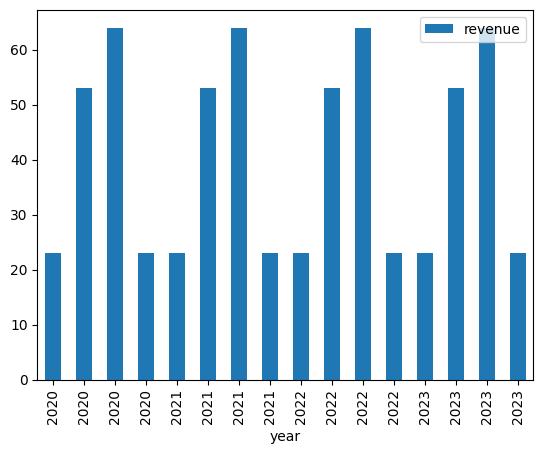

 I should show the chart
Action: Python_REPL
Action Input: plt.show()
Observation: 
Thought:
    Final Answer: A bar chart of year and revenue has been created and is visible.

> Finished chain.


'A bar chart of year and revenue has been created and is visible.'

In [11]:
req = "Show a bar graph visulising the revenue against the year"
agent_executor.run(req)



> Entering new AgentExecutor chain...

Thought: I need to get the data first
Action: Data tool
Action Input: revenue by quarter

> Entering new AgentExecutor chain...
Thought: I need to aggregate the data by quarter
Action: python_repl_ast
Action Input: df.groupby('quarter')['revenue'].sum()
Observation: quarter
q1     92
q2    212
q3    256
q4     92
Name: revenue, dtype: int64
Thought: I now know the final answer
Final Answer: The total revenue by quarter is q1 = 92, q2 = 212, q3 = 256, and q4 = 92.

> Finished chain.

Observation: The total revenue by quarter is q1 = 92, q2 = 212, q3 = 256, and q4 = 92.
Thought:
Action: Python_REPL
Action Input: import matplotlib.pyplot as plt, plt.bar([1,2,3,4], [92, 212, 256, 92]), plt.title('Revenue by Quarter'), plt.xlabel('Quarter'), plt.ylabel('Revenue')
Observation: SyntaxError('invalid syntax', ('<string>', 1, 41, "import matplotlib.pyplot as plt, plt.bar([1,2,3,4], [92, 212, 256, 92]), plt.title('Revenue by Quarter'), plt.xlabel('Quarter'

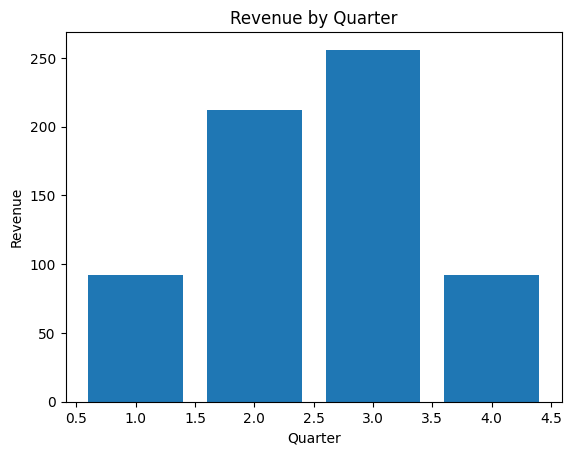


Observation: 
Thought:
Final Answer: A bar chart of the revenue by quarter.

> Finished chain.


'A bar chart of the revenue by quarter.'

In [23]:
req = "Plot a bar chart of the revenue each quarter"
agent_executor.run(req)

## Pie Chart



> Entering new AgentExecutor chain...

Thought: I need to calculate the total revenue of each quarter
Action: Data tool
Action Input: groupby quarter and sum revenue

> Entering new AgentExecutor chain...
Thought: I need to use groupby and sum to get the result
Action: python_repl_ast
Action Input: df.groupby('quarter')['revenue'].sum()
Observation: quarter
q1     92
q2    212
q3    256
q4     92
Name: revenue, dtype: int64
Thought: the sum of revenue by quarter is the final answer
Final Answer: 92, 212, 256, 92

> Finished chain.

Observation: 92, 212, 256, 92
Thought:

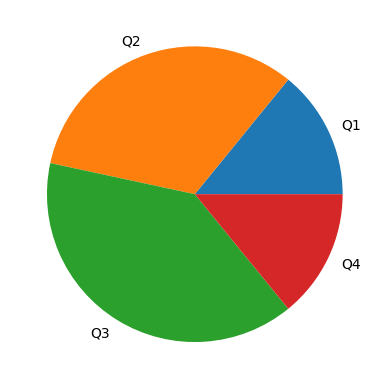


I need to plot the data I just calculated
Action: Python_REPL
Action Input: 
import matplotlib.pyplot as plt
labels = ["Q1", "Q2", "Q3", "Q4"]
sizes = [92, 212, 256, 92]
plt.pie(sizes, labels=labels)
plt.show()
Observation: 
Thought: I now know the final answer
Final Answer: A pie chart with each quarter's revenue plotted.

> Finished chain.


"A pie chart with each quarter's revenue plotted."

In [25]:
req = "Plot a pie chart of the revenue each quarter"
agent_executor.run(req)



> Entering new AgentExecutor chain...

Thought: I need to first find the maximum revenue
Action: Data
Action Input: df['Revenue'].max()

> Entering new AgentExecutor chain...
Thought: I need to find the highest value in the revenue column
Action: python_repl_ast
Action Input: df['Revenue'].max()
Observation: KeyError: 'Revenue'
Thought: I am given an error, so I need to check what column I need to use
Action: python_repl_ast
Action Input: df['revenue'].max()
Observation: 64
Thought: I now know the final answer
Final Answer: 64

> Finished chain.

Observation: 64
Thought:
I now need to plot a pie chart
Action: Python_REPL
Action Input: import matplotlib.pyplot as plt; df.plot(kind='pie', y='Revenue', figsize=(5,5))
Observation: 
Thought:
I now know the final answer
Final Answer: A pie chart of the maximum revenue is plotted.

> Finished chain.


'A pie chart of the maximum revenue is plotted.'

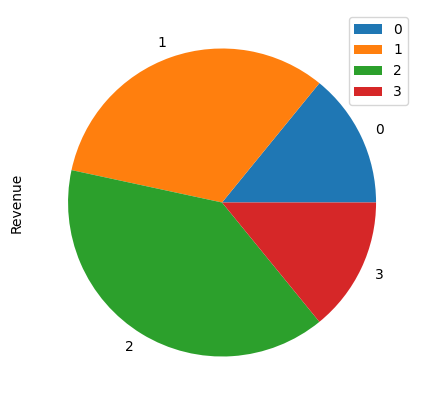

In [22]:
agent_executor.run("Plot a pie chart of the maximum revenue.")

## Try out on masked JBS data

In [90]:
def plot(df: pd.DataFrame, llm):
    pd_agent = create_pandas_dataframe_agent(
        llm=llm,
        df=df,
        verbose=True,
    )
    tools = load_tools(["python_repl"])
    
    data_tool = Tool(
        name="Data",
        func=pd_agent.run,
        description="Useful for when you need to answer questions about the data from the pandas dataframe. Use this more than the Python tool if the question is about the revenue, year, etc like 'What the maximum reveue?', 'Which year has the lowest revenue?'"
    )
    tools.append(data_tool)

    prompt = ZeroShotAgent.create_prompt(
    tools=tools,
    prefix="Fulfill the following request as best you can. You have access to the following tools:",
    suffix="""Begin! When looking for data, use the Data tool in its entierly. 
    The given dataframe is\n
    df = {dataframe}\n
    
    Request: {input}\n

    {agent_scratchpad}
    """,
    input_variables=["input", "dataframe", "agent_scratchpad"]
    )

    llm_chain = LLMChain(llm=llm, prompt=prompt)
    tool_names = [tool.name for tool in tools]
    agent = ZeroShotAgent(llm_chain=llm_chain, allowed_tools=tool_names)

    # agent executor
    agent_executor = AgentExecutor.from_agent_and_tools(
        agent=agent, tools=tools, verbose=True
    )

    return agent_executor





> Entering new AgentExecutor chain...

Thought: I need to figure out how to plot a bar chart with python
Action: Python_REPL
Action Input: import matplotlib.pyplot as plt
Observation: 
Thought:
    Now I need to use the data to plot a bar chart
Action: Data
Action Input: df.plot.bar(x='Year',y='Revenue')

> Entering new AgentExecutor chain...
Thought: I need to figure out how to make a bar plot of the given data
Action: python_repl_ast
Action Input: df.plot.bar(x = 'year', y = 'revenue')
Observation: Axes(0.125,0.11;0.775x0.77)
Thought: I now know how to make the bar plot
Final Answer: Use the command df.plot.bar(x = 'year', y = 'revenue') to create a bar plot of year and revenue for df.

> Finished chain.

Observation: Use the command df.plot.bar(x = 'year', y = 'revenue') to create a bar plot of year and revenue for df.
Thought:
    I now have the command to plot a bar chart
Action: Python_REPL 
Action Input: df.plot.bar(x='Year',y='Revenue')
Observation: NameError("name 'df' is no

'Agent stopped due to iteration limit or time limit.'

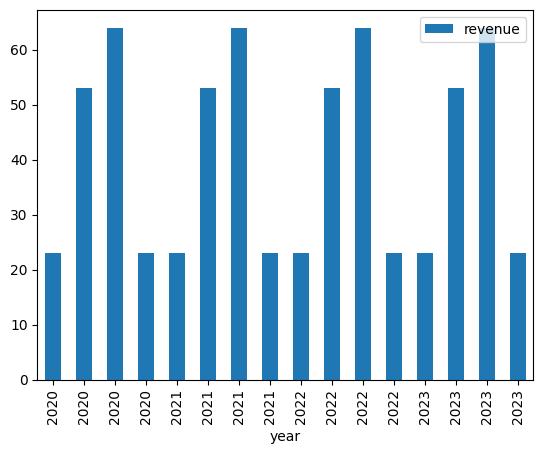

In [21]:
plot_executer.run("Plot a bar chart between year and revenue")

In [57]:
df = pd.read_csv("data/central_london_slide4.csv")
df.head(2)

,Year,Quarter,Total-City,Total-West-end
0,2013,Q1,1530,1251
1,2013,Q2,2112,1053


In [91]:
plot_executer = plot(df, chat_llm)



> Entering new AgentExecutor chain...


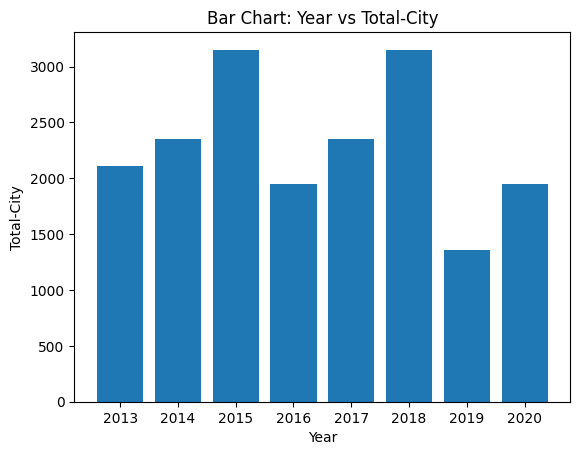

Question: How can I plot a bar chart between Year and Total-City?
Thought: I need to use the Python_REPL tool to execute the necessary Python code for plotting a bar chart.
Action: Python_REPL
Action Input: 
```python
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame({'Year': [2013, 2013, 2013, 2013, 2014, 2014, 2014, 2014, 2015, 2015, 2015, 2015, 2016, 2016, 2016, 2016, 2017, 2017, 2017, 2017, 2018, 2018, 2018, 2018, 2019, 2019, 2019, 2019, 2020, 2020, 2020, 2020],
                   'Quarter': ['Q1', 'Q2', 'Q3', 'Q4', 'Q1', 'Q2', 'Q3', 'Q4', 'Q1', 'Q2', 'Q3', 'Q4', 'Q1', 'Q2', 'Q3', 'Q4', 'Q1', 'Q2', 'Q3', 'Q4', 'Q1', 'Q2', 'Q3', 'Q4', 'Q1', 'Q2', 'Q3', 'Q4', 'Q1', 'Q2', 'Q3', 'Q4'],
                   'Total-City': [1530, 2112, 251, 1234, 1224, 1234, 2351, 1251, 1053, 1351, 3151, 1335, 1345, 1355, 1255, 1950, 1058, 1954, 1234, 2351, 1251, 1053, 1351, 3151, 1335, 1345, 1355, 1255, 1950, 1058, 1255, 1950],
                   'Total-West-end': [1251, 1053, 1351, 31

OutputParserException: Could not parse LLM output: `I now know the final answer.`

In [75]:
plot_executer.run(input="plot a bar chart between Year and Total-City", dataframe=df)

In [92]:
plot_executer.run(input="Plot a pie chart between Quarter and Total-City", dataframe=df)



> Entering new AgentExecutor chain...
Question: How can I plot a pie chart between Quarter and Total-City?
Thought: I need to use the Python_REPL tool to write code that will generate a pie chart using the data from the dataframe.
Action: Python_REPL
Action Input: 
```python
import matplotlib.pyplot as plt

quarters = df['Quarter']
total_city = df['Total-City']

plt.pie(total_city, labels=quarters, autopct='%1.1f%%')
plt.title('Total-City by Quarter')
plt.show()
```
Observation: NameError("name 'df' is not defined")
Thought:

OutputParserException: Could not parse LLM output: `I forgot to import the pandas library and assign the dataframe to the variable 'df'. I need to fix that in order to execute the code.`

In [55]:
df.head()

,Year,Quarter,Total-City,Total-West-end
0,2013,Q1,1530,1251
1,2013,Q2,2112,1053
2,2013,Q3,251,1351
3,2013,Q4,1234,3151
4,2014,Q1,1224,1335




> Entering new AgentExecutor chain...

Thought: I need to plot the data
Action: Python_REPL
Action Input: import pandas as pd
              import matplotlib.pyplot as plt
              df.plot.bar()
              plt.show()
Observation: IndentationError('unexpected indent', ('<string>', 2, 14, '              import matplotlib.pyplot as plt\n'))
Thought: I didn't indent the code correctly.
Action: Python_REPL
Action Input: import pandas as pd
              import matplotlib.pyplot as plt
              df.plot.bar()
              plt.show()
Observation: IndentationError('unexpected indent', ('<string>', 2, 14, '              import matplotlib.pyplot as plt\n'))
Thought: I need to check the indentation
Action: Python_REPL
Action Input: import pandas as pd
    import matplotlib.pyplot as plt
    df.plot.bar()
    plt.show()
Observation: IndentationError('unexpected indent', ('<string>', 2, 4, '    import matplotlib.pyplot as plt\n'))
Thought: I need to indent correctly
Action: Python_RE

'Agent stopped due to iteration limit or time limit.'

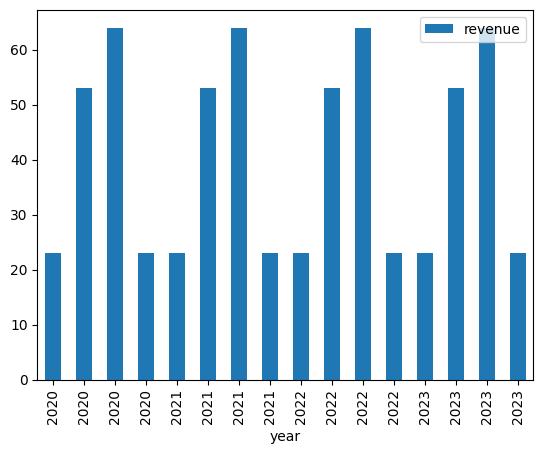

In [56]:
plot_executer.run(input="plot a bar chart", dataframe=df)



> Entering new AgentExecutor chain...


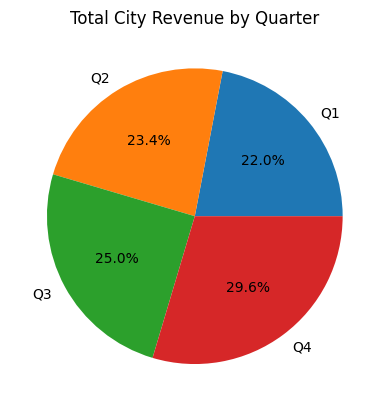

Question: What is the relationship between the quarters and the total city revenue?
Thought: To visualize the relationship between the quarters and total city revenue, we can use a pie chart.
Action: Python_REPL
Action Input: 
```
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame({'Year': [2013, 2013, 2013, 2013, 2014, 2014, 2014, 2014, 2015, 2015, 2015, 2015, 2016, 2016, 2016, 2016, 2017, 2017, 2017, 2017, 2018, 2018, 2018, 2018, 2019, 2019, 2019, 2019, 2020, 2020, 2020, 2020],
                   'Quarter': ['Q1', 'Q2', 'Q3', 'Q4', 'Q1', 'Q2', 'Q3', 'Q4', 'Q1', 'Q2', 'Q3', 'Q4', 'Q1', 'Q2', 'Q3', 'Q4', 'Q1', 'Q2', 'Q3', 'Q4', 'Q1', 'Q2', 'Q3', 'Q4', 'Q1', 'Q2', 'Q3', 'Q4', 'Q1', 'Q2', 'Q3', 'Q4'],
                   'Total-City': [1530, 2112, 251, 1234, 1224, 1234, 2351, 1251, 1053, 1351, 3151, 1335, 1345, 1355, 1255, 1950, 1058, 1954, 1234, 2351, 1251, 1053, 1351, 3151, 1335, 1345, 1355, 1255, 1950, 1058, 1255, 1950],
                   'Total-West-end': [1251, 1

'The pie chart visually represents the relationship between the quarters and the total city revenue.'

In [93]:
plot_executer.run(input="Plot a pie chart between Quarter and Total-City", dataframe=df)